# NLP Assignment 1 - Fake or Real News

## Natural Language Processing and Text Mining

By: Moutaz Al-Huneidi and Ignacio Mouawad

IE MBD 2019 A1

_________________________________________________________________________________

## Importing Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import nltk
import re
from matplotlib import pyplot
from nltk.corpus import stopwords
from nltk.corpus import brown
from nltk.tag import untag
from nltk import UnigramTagger
from nltk import RegexpTagger
from nltk import AffixTagger
from nltk import NgramTagger
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from nltk.stem import WordNetLemmatizer

__________________________________________________________________________________________________________________

## Loading the datasets

In [2]:
DATA_DIRECTORY = "C:/Users/ignac/Desktop/ie/mbd term 3/NLP/assignment"

In [3]:
news_train_csv = os.path.join(DATA_DIRECTORY, "fake_or_real_news_training.csv")

In [4]:
news_test_csv = os.path.join(DATA_DIRECTORY, "fake_or_real_news_test.csv")

In [5]:
news_train_original = pd.read_csv(
    news_train_csv,
    index_col="ID",
    encoding="utf-8"
)
news_train_original.head()

,title,text,label,X1,X2
ID,,,,,
8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,NaN,NaN
10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,NaN,NaN
3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,NaN,NaN
10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,NaN,NaN
875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,NaN,NaN


In [6]:
news_test = pd.read_csv(
    news_test_csv,
    index_col="ID",
    encoding="utf-8"
)
news_test.head()

,title,text
ID,,
10498,September New Homes Sales Rise——-Back To 1992 ...,September New Homes Sales Rise Back To 1992 Le...
2439,Why The Obamacare Doomsday Cult Can't Admit It...,But when Congress debated and passed the Patie...
864,"Sanders, Cruz resist pressure after NY losses,...",The Bernie Sanders and Ted Cruz campaigns vowe...
4128,Surviving escaped prisoner likely fatigued and...,Police searching for the second of two escaped...
662,Clinton and Sanders neck and neck in Californi...,No matter who wins California's 475 delegates ...


In [7]:
train = news_train_original.copy()

## Data Cleaning

In [8]:
train.describe()

,title,text,label,X1,X2
count,3999,3999,3999,33,2
unique,3968,3839,35,4,2
top,OnPolitics | 's politics blog,"Killing Obama administration rules, dismantlin...",REAL,REAL,FAKE
freq,4,41,1990,17,1


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3999 entries, 8476 to 9673
Data columns (total 5 columns):
title    3999 non-null object
text     3999 non-null object
label    3999 non-null object
X1       33 non-null object
X2       2 non-null object
dtypes: object(5)
memory usage: 187.5+ KB


In [10]:
train.isnull().sum()

title       0
text        0
label       0
X1       3966
X2       3997
dtype: int64

Here we can note that there are no missing values in the title, text, or label columns in the train dataset, but there seems to be a large number of nulls in the X1 and X2 columns, so this will require further investigation.

In [11]:
train[-train["X1"].isna()]

,title,text,label,X1,X2
ID,,,,,
599,Election Day: No Legal Pot In Ohio,Democrats Lose In The South,Election Day: No Legal Pot In Ohio; Democrats ...,REAL,NaN
10194,Who rode it best? Jesse Jackson mounts up to f...,Leonardo DiCaprio to the rescue?,Who rode it best? Jesse Jackson mounts up to f...,FAKE,NaN
356,Black Hawk crashes off Florida,human remains found,(CNN) Thick fog forced authorities to suspend ...,REAL,NaN
2786,Afghanistan: 19 die in air attacks on hospital,U.S. investigating,(CNN) Aerial bombardments blew apart a Doctors...,REAL,NaN
3622,Al Qaeda rep says group directed Paris magazin...,US issues travel warning,A member of Al Qaeda's branch in Yemen said Fr...,REAL,NaN
7375,Shallow 5.4 magnitude earthquake rattles centr...,shakes buildings in Rome,00 UTC © USGS Map of the earthquake's epicent...,FAKE,NaN
9097,ICE Agent Commits Suicide in NYC,Leaves Note Revealing Gov’t Plans to Round-up...,Email Print After writing a lengthy suicide no...,FAKE,NaN
9203,Political Correctness for Yuengling Brewery,What About Our Opioid Epidemic?,We Are Change \n\nIn today’s political climate...,FAKE,NaN
1602,Poll gives Biden edge over Clinton against GOP...,VP meets with Trumka,A new national poll shows Vice President Biden...,REAL,NaN


So here we can note that there appears to be a separation between the main title and the subtitle of an article, resulting in the text being shifted into the next column.

In [12]:
print("X1 has %s non-null values" % len(train[-train["X1"].isna()]))
print("X2 has %s non-null values" % len(train[-train["X2"].isna()]))

X1 has 33 non-null values
X2 has 2 non-null values


So there are 33 rows that have misplaced labels ovarall, of which there are two rows that have 2 subtitles shifting the label to X2, thereby leaving 31 rows with their label in the X1 column. These rows need to be ammended such that they adhere to the format of the remainder of the dataset. 

To achieve this, if `X2` is not null, then the value of the `title` column for that row will be made to equal the concatenation of the `title`, `text`, and `X1` columns, and the `label` will be made to equal the `X2` column. Following that, the columns `X1` and `X2` will be set to equal nulls.

For the 31 rows with their labels in `X1`, the `title` column for that row will be made to equal the concatenation of the `title` and `text` columns, and the `label` will be made to equal the value in the `X1` column.

In [13]:
for i in range(len(train)):
    if not pd.isnull(train.iloc[i].X2):
        train["title"].iloc[i] = train["title"].iloc[i] + " " + train["text"].iloc[i] + " " + train["label"].iloc[i]
        train["text"].iloc[i] = train["X1"].iloc[i]
        train["label"].iloc[i] = train["X2"].iloc[i]
        train["X1"].iloc[i] = np.nan
        train["X2"].iloc[i] = np.nan

for i in range(len(train)):
    if not pd.isnull(train.iloc[i].X1):
        train["title"].iloc[i] = train["title"].iloc[i] + " " + train["text"].iloc[i]
        train["text"].iloc[i] = train["label"].iloc[i]
        train["label"].iloc[i] = train["X1"].iloc[i]
        train["X1"].iloc[i] = np.nan

Checking that there are no columns remaining with misplaced tags in columns X1 and X2:

In [14]:
train[-train["X1"].isna()]

,title,text,label,X1,X2
ID,,,,,


In [15]:
train[-train["X2"].isna()]

,title,text,label,X1,X2
ID,,,,,


Both of those columns are now empty and can be safely dropped.

In [16]:
train = train.drop(["X1", "X2"], axis=1)
train.head()

,title,text,label
ID,,,
8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


Now that the columns have been corrected, the processes of cleaning and pre-processing the data can begin.

To start, the contents of the `title` and `text` columns will be converted to lowercase letters, as this will allow us to work with the data in a more consistent manner in future steps.

In [17]:
train["text"] = train["text"].str.lower()
train["title"] = train["title"].str.lower()

In [18]:
train_copy = train.copy()
labels = train_copy["label"]

Looking at the data, there are symbols and numerical values within the `title` and  `text` and fields, which may influence the manner in which the data is considered in future steps. Therefore they will be removed using a regex command.

To do this, firstly, a function needs to be defined that can be applied to the dataframe, in this function the only non alpha character that will be kept is the apostrophe, as it can be seen in contractions or possessive nouns.

In [19]:
def regex(text):
    return re.sub (r"([^a-zA-Z'’ ]+?)", '', text)

In [20]:
train["title"] = train["title"].apply(regex, 0)
train["text"] = train["text"].apply(regex, 0)

In [21]:
train.head()

,title,text,label
ID,,,
8476,you can smell hillary’s fear,daniel greenfield a shillman journalism fellow...,FAKE
10294,watch the exact moment paul ryan committed pol...,google pinterest digg linkedin reddit stumbleu...,FAKE
3608,kerry to go to paris in gesture of sympathy,us secretary of state john f kerry said monday...,REAL
10142,bernie supporters on twitter erupt in anger ag...,kaydee king kaydeeking november the lesson ...,FAKE
875,the battle of new york why this primary matters,it's primary day in new york and frontrunners ...,REAL


After running the models on the `title` and `text` fields separately, the results were sub-optimal and the dataframes were very large and caused memory errors in python. Based on that, the a new column was made that combined the text in both of those columns into `total_text`. 

NOTE: All code cells that are in comments are left over to show what was intitally done. Though, some of the cells were written over.

In [22]:
train["total_text"] = train["title"] + " " + train["text"]
train.head()

,title,text,label,total_text
ID,,,,
8476,you can smell hillary’s fear,daniel greenfield a shillman journalism fellow...,FAKE,you can smell hillary’s fear daniel greenfield...
10294,watch the exact moment paul ryan committed pol...,google pinterest digg linkedin reddit stumbleu...,FAKE,watch the exact moment paul ryan committed pol...
3608,kerry to go to paris in gesture of sympathy,us secretary of state john f kerry said monday...,REAL,kerry to go to paris in gesture of sympathy us...
10142,bernie supporters on twitter erupt in anger ag...,kaydee king kaydeeking november the lesson ...,FAKE,bernie supporters on twitter erupt in anger ag...
875,the battle of new york why this primary matters,it's primary day in new york and frontrunners ...,REAL,the battle of new york why this primary matter...


The `title` and `text` columns were then dropped, as all of their information is contained inside of `total_text`.

In [23]:
train.drop(["title", "text"], axis=1, inplace=True)
train.head()

,label,total_text
ID,,
8476,FAKE,you can smell hillary’s fear daniel greenfield...
10294,FAKE,watch the exact moment paul ryan committed pol...
3608,REAL,kerry to go to paris in gesture of sympathy us...
10142,FAKE,bernie supporters on twitter erupt in anger ag...
875,REAL,the battle of new york why this primary matter...


To start with the processing of the data, TF-IDF analysis will be run on both the `title` and the `text` columns of the training data.

NOTE: This was changed and only applied on the `total_text` column, as explained above.

## Tokenizer

Moving forward, the words in each of the articles need to be tokenized, so that they can be tagged for their part of speech. Given that we are trying to classify the entire document, the tokenization will be conducted on the entire document, rather than breaking down the document into sentences and then applying the tokenization on each sentence.

To start, a new dataframe will be created in order to house the tokens as a list. NOTE:THE FOLLOWING IS NO LONGER TRUE, AS IT DID NOT PROVIDE BETTER RESULTS AND IT WAS ONLY RUN ON THE `total_text` COLUMN.

This will be done individually for the `title` and `text` columns, as they may hold interesting findings when trying to classify whether an article is fake or not.


In [24]:
train["tokens"] = train["total_text"].apply(nltk.word_tokenize, 0)
train.head()

,label,total_text,tokens
ID,,,
8476,FAKE,you can smell hillary’s fear daniel greenfield...,"[you, can, smell, hillary, ’, s, fear, daniel,..."
10294,FAKE,watch the exact moment paul ryan committed pol...,"[watch, the, exact, moment, paul, ryan, commit..."
3608,REAL,kerry to go to paris in gesture of sympathy us...,"[kerry, to, go, to, paris, in, gesture, of, sy..."
10142,FAKE,bernie supporters on twitter erupt in anger ag...,"[bernie, supporters, on, twitter, erupt, in, a..."
875,REAL,the battle of new york why this primary matter...,"[the, battle, of, new, york, why, this, primar..."


In [25]:
#tokenized_title_train = pd.DataFrame(index=train.index)
#tokenized_title_train["tokens"] = train["title"].apply(nltk.word_tokenize, 0)

#tokenized_text_train = pd.DataFrame(index=train.index)
#tokenized_text_train["tokens"] = train["text"].apply(nltk.word_tokenize, 0)


## POS Tagging

Having now tokenized the words in each of the documents in the dataset, we can now begin assigning the tag to each word in the dataset using a bigram tagger. Both these taggers will have unigram taggers as their backoff, which, in turn, will hve an affix tagger, that will have a regeular expresstion tagger as the final tagger. These taggers have been trained and tested on the Brown dataset, and has achieved an accuracy of 96.1% on the test dataset.

Initally, the nltk pos_tag function was used, but after looking over the result, some rather obvious errors were present in the tags assigned, and therefore an ngram tagger was selected to take its place, as, overall, it appeared to be better suited for this dataset.

In [26]:
brown_news_tagged = brown.tagged_sents(categories='news', tagset='universal')
brown_news_words = brown.tagged_words(categories='news',  tagset='universal')
brown_train = brown_news_tagged[100:]
brown_test = brown_news_tagged[:100]

In [27]:
regexp_tagger = RegexpTagger(
     [(r'^-?[0-9]+(.[0-9]+)?$', 'NUM'),   # cardinal numbers
      (r'(The|the|A|a|An|an)$', 'DET'),   # articles
      (r'.*able$', 'ADJ'),                # adjectives
      (r'.*ness$', 'NOUN'),               # nouns formed from adjectives
      (r'.*ly$', 'ADV'),                  # adverbs
      (r'.*s$', 'NOUN'),                  # plural nouns
      (r'.*ing$', 'VERB'),                # gerunds
      (r'.*ed$', 'VERB'),                 # past tense verbs
      (r'.*', 'NOUN')                     # nouns (default)
])

affix_tagger = AffixTagger(brown_train, backoff=regexp_tagger)
unigram_tagger = UnigramTagger(brown_train, backoff = affix_tagger)
bigram_tagger = NgramTagger(2, brown_train, backoff = unigram_tagger)
bigram_tagger.evaluate(brown_test)

0.9611992945326279

In [28]:
def tag_corpus(text):
    try:
        tags = bigram_tagger.tag(text)
        #tags.append(bigram_tagger.tag(corpus_text))
        
    except Exception as e:
        print(str(e))
    return tags

In [29]:
train["tags"] = train.tokens.apply(tag_corpus, 0)

In [30]:
train.head()

,label,total_text,tokens,tags
ID,,,,
8476,FAKE,you can smell hillary’s fear daniel greenfield...,"[you, can, smell, hillary, ’, s, fear, daniel,...","[(you, PRON), (can, VERB), (smell, VERB), (hil..."
10294,FAKE,watch the exact moment paul ryan committed pol...,"[watch, the, exact, moment, paul, ryan, commit...","[(watch, VERB), (the, DET), (exact, ADJ), (mom..."
3608,REAL,kerry to go to paris in gesture of sympathy us...,"[kerry, to, go, to, paris, in, gesture, of, sy...","[(kerry, NOUN), (to, PRT), (go, VERB), (to, PR..."
10142,FAKE,bernie supporters on twitter erupt in anger ag...,"[bernie, supporters, on, twitter, erupt, in, a...","[(bernie, NOUN), (supporters, NOUN), (on, ADP)..."
875,REAL,the battle of new york why this primary matter...,"[the, battle, of, new, york, why, this, primar...","[(the, DET), (battle, NOUN), (of, ADP), (new, ..."


In [31]:
#tokenized_title_train["tags"] = tokenized_title_train.tokens.apply(tag_corpus, 0)
#tokenized_title_train.head()

#tokenized_text_train["tags"] = tokenized_text_train.tokens.apply(tag_corpus, 0)
#tokenized_text_train.head()

Counting Tags

In [32]:
def count_tags(tags):
    return Counter(tag for word,tag in tags)

In [33]:
train["tag_counts"] = train.tags.apply(count_tags, 0)
train.head()

,label,total_text,tokens,tags,tag_counts
ID,,,,,
8476,FAKE,you can smell hillary’s fear daniel greenfield...,"[you, can, smell, hillary, ’, s, fear, daniel,...","[(you, PRON), (can, VERB), (smell, VERB), (hil...","{'PRON': 61, 'VERB': 248, 'NOUN': 446, 'DET': ..."
10294,FAKE,watch the exact moment paul ryan committed pol...,"[watch, the, exact, moment, paul, ryan, commit...","[(watch, VERB), (the, DET), (exact, ADJ), (mom...","{'VERB': 85, 'DET': 57, 'ADJ': 25, 'NOUN': 150..."
3608,REAL,kerry to go to paris in gesture of sympathy us...,"[kerry, to, go, to, paris, in, gesture, of, sy...","[(kerry, NOUN), (to, PRT), (go, VERB), (to, PR...","{'NOUN': 170, 'PRT': 19, 'VERB': 70, 'ADP': 66..."
10142,FAKE,bernie supporters on twitter erupt in anger ag...,"[bernie, supporters, on, twitter, erupt, in, a...","[(bernie, NOUN), (supporters, NOUN), (on, ADP)...","{'NOUN': 182, 'ADP': 52, 'ADJ': 28, 'DET': 44,..."
875,REAL,the battle of new york why this primary matter...,"[the, battle, of, new, york, why, this, primar...","[(the, DET), (battle, NOUN), (of, ADP), (new, ...","{'DET': 36, 'NOUN': 112, 'ADP': 37, 'ADJ': 26,..."


In [34]:
#tokenized_title_train["tag_counts"] = tokenized_title_train.tags.apply(count_tags, 0)

#tokenized_text_train["tag_counts"] = tokenized_text_train.tags.apply(count_tags, 0)


Now that the counts, have been found, converting them to columns is the next step. The will be done using function that will expand the dictionary into columns, thereby enabling us to work with those values more easily.

Splitting the dictionary into separate columns.

In [35]:
tag_counts_text = train['tag_counts'].apply(pd.Series)

In [36]:
train = pd.concat([train, tag_counts_text], axis = 1).drop('tag_counts', axis = 1)
train.head()

,label,total_text,tokens,tags,PRON,VERB,NOUN,DET,ADP,ADJ,PRT,ADV,CONJ,NUM,X,.
ID,,,,,,,,,,,,,,,,
8476,FAKE,you can smell hillary’s fear daniel greenfield...,"[you, can, smell, hillary, ’, s, fear, daniel,...","[(you, PRON), (can, VERB), (smell, VERB), (hil...",61.0,248.0,446.0,188.0,164.0,83.0,49.0,75.0,47.0,5.0,NaN,NaN
10294,FAKE,watch the exact moment paul ryan committed pol...,"[watch, the, exact, moment, paul, ryan, commit...","[(watch, VERB), (the, DET), (exact, ADJ), (mom...",22.0,85.0,150.0,57.0,60.0,25.0,23.0,29.0,11.0,3.0,1.0,NaN
3608,REAL,kerry to go to paris in gesture of sympathy us...,"[kerry, to, go, to, paris, in, gesture, of, sy...","[(kerry, NOUN), (to, PRT), (go, VERB), (to, PR...",18.0,70.0,170.0,41.0,66.0,28.0,19.0,19.0,11.0,NaN,NaN,NaN
10142,FAKE,bernie supporters on twitter erupt in anger ag...,"[bernie, supporters, on, twitter, erupt, in, a...","[(bernie, NOUN), (supporters, NOUN), (on, ADP)...",9.0,65.0,182.0,44.0,52.0,28.0,16.0,14.0,4.0,1.0,NaN,1.0
875,REAL,the battle of new york why this primary matter...,"[the, battle, of, new, york, why, this, primar...","[(the, DET), (battle, NOUN), (of, ADP), (new, ...",12.0,60.0,112.0,36.0,37.0,26.0,18.0,7.0,13.0,4.0,NaN,NaN


In [37]:
train.fillna(0, inplace=True)
train.head()

,label,total_text,tokens,tags,PRON,VERB,NOUN,DET,ADP,ADJ,PRT,ADV,CONJ,NUM,X,.
ID,,,,,,,,,,,,,,,,
8476,FAKE,you can smell hillary’s fear daniel greenfield...,"[you, can, smell, hillary, ’, s, fear, daniel,...","[(you, PRON), (can, VERB), (smell, VERB), (hil...",61.0,248.0,446.0,188.0,164.0,83.0,49.0,75.0,47.0,5.0,0.0,0.0
10294,FAKE,watch the exact moment paul ryan committed pol...,"[watch, the, exact, moment, paul, ryan, commit...","[(watch, VERB), (the, DET), (exact, ADJ), (mom...",22.0,85.0,150.0,57.0,60.0,25.0,23.0,29.0,11.0,3.0,1.0,0.0
3608,REAL,kerry to go to paris in gesture of sympathy us...,"[kerry, to, go, to, paris, in, gesture, of, sy...","[(kerry, NOUN), (to, PRT), (go, VERB), (to, PR...",18.0,70.0,170.0,41.0,66.0,28.0,19.0,19.0,11.0,0.0,0.0,0.0
10142,FAKE,bernie supporters on twitter erupt in anger ag...,"[bernie, supporters, on, twitter, erupt, in, a...","[(bernie, NOUN), (supporters, NOUN), (on, ADP)...",9.0,65.0,182.0,44.0,52.0,28.0,16.0,14.0,4.0,1.0,0.0,1.0
875,REAL,the battle of new york why this primary matter...,"[the, battle, of, new, york, why, this, primar...","[(the, DET), (battle, NOUN), (of, ADP), (new, ...",12.0,60.0,112.0,36.0,37.0,26.0,18.0,7.0,13.0,4.0,0.0,0.0


In [38]:
#tag_counts_title = tokenized_title_train['tag_counts'].apply(pd.Series)
#tag_counts_text = tokenized_text_train['tag_counts'].apply(pd.Series)

In [39]:
#tokenized_title_train = pd.concat([tokenized_title_train, tag_counts_title], axis = 1).drop('tag_counts', axis = 1)

#tokenized_text_train = pd.concat([tokenized_text_train, tag_counts_text], axis = 1).drop('tag_counts', axis = 1)


In [40]:
#tokenized_title_train.fillna(0, inplace=True)

#tokenized_text_train.fillna(0, inplace=True)

Several feature will now be created, which include: 
- length in chracters
- number of words
- average word lenght
- number of sentences
- words per sentence
- characters per sentence
- percentage of each part of speech of the total number of words

In [41]:
def word_counter(df):
    return df["PRON"]+df["VERB"]+df["NOUN"]+df["DET"]+df["ADJ"]+df["ADP"]+df["PRT"]+df["."]+df["ADV"]+df["CONJ"]+df["NUM"]+df["X"]

In [42]:
train["word_count"] = train.apply(word_counter, 1)
train.head()

,label,total_text,tokens,tags,PRON,VERB,NOUN,DET,ADP,ADJ,PRT,ADV,CONJ,NUM,X,.,word_count
ID,,,,,,,,,,,,,,,,,
8476,FAKE,you can smell hillary’s fear daniel greenfield...,"[you, can, smell, hillary, ’, s, fear, daniel,...","[(you, PRON), (can, VERB), (smell, VERB), (hil...",61.0,248.0,446.0,188.0,164.0,83.0,49.0,75.0,47.0,5.0,0.0,0.0,1366.0
10294,FAKE,watch the exact moment paul ryan committed pol...,"[watch, the, exact, moment, paul, ryan, commit...","[(watch, VERB), (the, DET), (exact, ADJ), (mom...",22.0,85.0,150.0,57.0,60.0,25.0,23.0,29.0,11.0,3.0,1.0,0.0,466.0
3608,REAL,kerry to go to paris in gesture of sympathy us...,"[kerry, to, go, to, paris, in, gesture, of, sy...","[(kerry, NOUN), (to, PRT), (go, VERB), (to, PR...",18.0,70.0,170.0,41.0,66.0,28.0,19.0,19.0,11.0,0.0,0.0,0.0,442.0
10142,FAKE,bernie supporters on twitter erupt in anger ag...,"[bernie, supporters, on, twitter, erupt, in, a...","[(bernie, NOUN), (supporters, NOUN), (on, ADP)...",9.0,65.0,182.0,44.0,52.0,28.0,16.0,14.0,4.0,1.0,0.0,1.0,416.0
875,REAL,the battle of new york why this primary matter...,"[the, battle, of, new, york, why, this, primar...","[(the, DET), (battle, NOUN), (of, ADP), (new, ...",12.0,60.0,112.0,36.0,37.0,26.0,18.0,7.0,13.0,4.0,0.0,0.0,325.0


In [43]:
#tokenized_text_train["word_count"] = tokenized_text_train.apply(word_counter, 1)

#tokenized_title_train["word_count"] = tokenized_title_train.apply(word_counter, 1)


In [44]:
train["length"] = train['total_text'].apply(len, 0)

In [45]:
train["length"] = pd.to_numeric(train["length"])

In [46]:
#tokenized_text_train["text_length"] = tokenized_text_train['text'].apply(len, 0)
#tokenized_title_train["title_length"] = tokenized_title_train['text'].apply(len, 0)
#tokenized_text_train["text_length"] = pd.to_numeric(tokenized_text_train["text_length"])
#tokenized_title_train["title_length"] = pd.to_numeric(tokenized_text_train["title_length"])

In [47]:
train["avg_word_length"] = train["length"] / train["word_count"]

In [48]:
#tokenized_title_train["avg_word_length"] = tokenized_title_train["title_length"] / tokenized_title_train["word_count"]
#tokenized_text_train["avg_word_length"] = tokenized_text_train["text_length"] / tokenized_text_train["word_count"]

In [49]:
number_of_sentences = train_copy.text.apply((nltk.sent_tokenize),0)
train["number_of_sentences"] = number_of_sentences.apply(len,0)

In [50]:
train["number_of_sentences"] = pd.to_numeric(train["number_of_sentences"])

In [51]:
train["words_per_sentence"] = ""

In [52]:
train["words_per_sentence"] = pd.to_numeric(train["words_per_sentence"])

In [53]:
train["words_per_sentence"] = train["word_count"] / train["number_of_sentences"]

In [54]:
train["words_per_sentence"].fillna(0,inplace=True)

In [55]:
train["characters_per_sentence"] = train["length"] / train["number_of_sentences"]

In [56]:
train.replace([np.inf, -np.inf], np.nan, inplace=True)

In [57]:
train.fillna(0,inplace=True)

In [58]:
#train = tokenized_text_train.add_prefix('text_')

In [59]:
#tokenized_title_train = tokenized_title_train.add_prefix('title_')

In [60]:
#train_comb = pd.concat([tokenized_text_train, tokenized_title_train], axis=1)

In [61]:
train["adj_per"] = train["ADJ"] / train["word_count"]

In [62]:
train["verb_per"] = train["VERB"] / train["word_count"]

In [63]:
train["noun_per"] = train["NOUN"] / train["word_count"]

In [64]:
train["det_per"] = train["DET"] / train["word_count"]

In [65]:
train["adv_per"] = train["ADV"] / train["word_count"]

In [66]:
train["adp_per"] = train["ADP"] / train["word_count"]

In [67]:
train["prt_per"] = train["PRT"] / train["word_count"]

In [68]:
train["conj_per"] = train["CONJ"] / train["word_count"]

In [69]:
train["num_per"] = train["NUM"] / train["word_count"]

In [70]:
train["X_per"] = train["X"] / train["word_count"]

In [71]:
train["pron_per"] = train["PRON"] / train["word_count"]

In [72]:
train.head()

,label,total_text,tokens,tags,PRON,VERB,NOUN,DET,ADP,ADJ,...,verb_per,noun_per,det_per,adv_per,adp_per,prt_per,conj_per,num_per,X_per,pron_per
ID,,,,,,,,,,,,,,,,,,,,,
8476,FAKE,you can smell hillary’s fear daniel greenfield...,"[you, can, smell, hillary, ’, s, fear, daniel,...","[(you, PRON), (can, VERB), (smell, VERB), (hil...",61.0,248.0,446.0,188.0,164.0,83.0,...,0.181552,0.326501,0.137628,0.054905,0.120059,0.035871,0.034407,0.003660,0.000000,0.044656
10294,FAKE,watch the exact moment paul ryan committed pol...,"[watch, the, exact, moment, paul, ryan, commit...","[(watch, VERB), (the, DET), (exact, ADJ), (mom...",22.0,85.0,150.0,57.0,60.0,25.0,...,0.182403,0.321888,0.122318,0.062232,0.128755,0.049356,0.023605,0.006438,0.002146,0.047210
3608,REAL,kerry to go to paris in gesture of sympathy us...,"[kerry, to, go, to, paris, in, gesture, of, sy...","[(kerry, NOUN), (to, PRT), (go, VERB), (to, PR...",18.0,70.0,170.0,41.0,66.0,28.0,...,0.158371,0.384615,0.092760,0.042986,0.149321,0.042986,0.024887,0.000000,0.000000,0.040724
10142,FAKE,bernie supporters on twitter erupt in anger ag...,"[bernie, supporters, on, twitter, erupt, in, a...","[(bernie, NOUN), (supporters, NOUN), (on, ADP)...",9.0,65.0,182.0,44.0,52.0,28.0,...,0.156250,0.437500,0.105769,0.033654,0.125000,0.038462,0.009615,0.002404,0.000000,0.021635
875,REAL,the battle of new york why this primary matter...,"[the, battle, of, new, york, why, this, primar...","[(the, DET), (battle, NOUN), (of, ADP), (new, ...",12.0,60.0,112.0,36.0,37.0,26.0,...,0.184615,0.344615,0.110769,0.021538,0.113846,0.055385,0.040000,0.012308,0.000000,0.036923


In [73]:
train.replace([np.inf, -np.inf], np.nan, inplace=True)
train.fillna(0,inplace=True)

## Lemmatization

Lemmas for each of the words will now be found.

In [74]:
lemmatizer = nltk.stem.WordNetLemmatizer()


def lemmatize(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

In [75]:
train["lemma"] = train["tokens"].apply(lemmatize, 0)

## Vectorization

Diffferent Vectorization techniques will be tried. The one that provides the best results will be kept.

### TF-IDF

In [76]:
tf_idf_weighting = TfidfVectorizer(stop_words = "english")
tf_idf_train = tf_idf_weighting.fit_transform(train.total_text)
tf_idf = pd.DataFrame(tf_idf_train.A, columns=tf_idf_weighting.get_feature_names())

### N-Grams

In [77]:
ngrams_weighting = TfidfVectorizer(stop_words = "english", ngram_range=(1,3), tokenizer=lemmatize, min_df=2)
ngram_train = ngrams_weighting.fit_transform(train.total_text)
ngram = pd.DataFrame(ngram_train.A, columns=ngrams_weighting.get_feature_names())
ngram.head()

C:\Users\ignac\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


,,,,',b,c,d,e,f,g,...,’ t ’,’ v,’ v e,’ w,’ w e,’ w h,’ y,’ ’,’ ’,’ ’ s
0,0.633118,0.019923,0.000761,0.0,0.001417,0.001284,0.001415,0.000000,0.001444,0.00000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.629535,0.035121,0.002147,0.0,0.003997,0.001811,0.000000,0.000000,0.002036,0.00000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.613432,0.016036,0.000000,0.0,0.002074,0.001880,0.002071,0.000000,0.000000,0.00000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.588454,0.049027,0.013224,0.0,0.000000,0.001859,0.000000,0.003483,0.002090,0.00000,...,0.0,0.003977,0.003979,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.602517,0.017633,0.000000,0.0,0.000000,0.007578,0.000000,0.000000,0.000000,0.00345,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
ngram = ngram.set_index(train.index)

In [79]:
ngram.shape

(3999, 11959)

Below you will find code that was used in the previous attempts when the title and text were treated as separate entities.

In [80]:
#tf_idf_weighting = TfidfVectorizer()
#tf_idf_news_train = tf_idf_weighting.fit_transform(train.text)
#tf_idf_text = pd.DataFrame(tf_idf_news_train.A, columns=tf_idf_weighting.get_feature_names())

In [81]:
#tf_idf_text = tf_idf_text.add_prefix("text_")

In [82]:
#tf_idf_weighting = TfidfVectorizer()
#tf_idf_title_train = tf_idf_weighting.fit_transform(train.title)
#tf_idf_title = pd.DataFrame(tf_idf_title_train.A, columns=tf_idf_weighting.get_feature_names())

In [83]:
#tf_idf_title = tf_idf_title.set_index(train.index)

In [84]:
#tf_idf_title = tf_idf_title.add_prefix("title_")

In [85]:
#tf_idf_comb = pd.concat([tf_idf_text, tf_idf_title], axis=1)

Now we will combine the best vectorizer with the features that have been created into one dataframe.

In [86]:
train_all = pd.concat([train, ngram], axis=1)

## Data Visualization

From this graph we can note that the sample size is realtively equal for both the real and fake news article, hence bagging or bootstrapping won't be necessary.

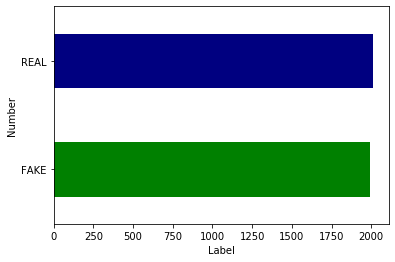

In [87]:
label_1 = train.groupby("label")
label_1.size().plot.barh(color=['green','navy'])
pyplot.xlabel("Label")
pyplot.ylabel("Number")
pyplot.show()

Text(0.5, 1.0, 'POS Taggers Distribution')

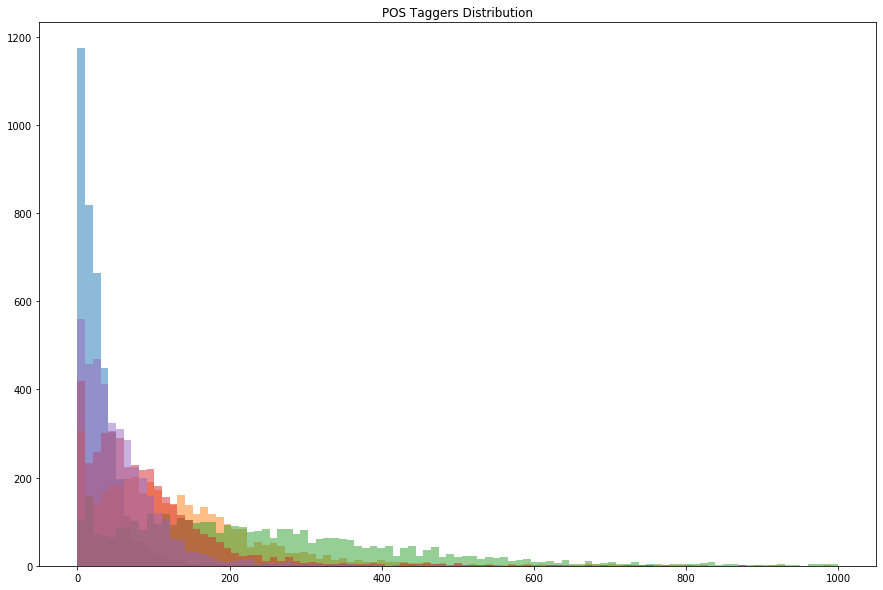

In [89]:
pyplot.figure(figsize=(15, 10))
bins = np.linspace(0, 1000, 100)

PRON = train["PRON"]
VERB = train["VERB"]
NOUN = train["NOUN"]
DET = train["DET"]
ADJ = train["ADJ"]
pyplot.hist(PRON, bins, alpha=0.5, label='PRON')
pyplot.hist(VERB, bins, alpha=0.5, label='VERB')
pyplot.hist(NOUN, bins, alpha=0.5, label='NOUN')
pyplot.hist(DET, bins, alpha=0.5, label='DET')
pyplot.hist(ADJ, bins, alpha=0.5, label='ADJ')
pyplot.title("POS Taggers Distribution")

Now the features that will not be inserted into a model will be dropped. 

In [90]:
train_all = train_all.drop(["label", "tags", "tokens", "total_text", "lemma", "PRON", "VERB", "NOUN", "DET", "ADJ", "ADP", "PRT", ".", "ADV", "CONJ" , "NUM", "X"], axis=1)

## Train/Test Splitting

Now that the data has been prepared, the train data will be split into a training set and a testing set to see the performance of our models.

In [91]:
x_train,x_test,y_train,y_test=train_test_split(train_all, labels, test_size=0.2, random_state=22)

The above combination of both sets results in lower performing models, or the models did not run. As a result, only the results from the vectorizers were inputted into the models, which is shown in the code below.

In [92]:
x_train_1,x_test_1,y_train_1,y_test_1=train_test_split(ngram, labels, test_size=0.2, random_state=22)

## Naive Bayes

In [93]:
naive_bayes = MultinomialNB()
naive_bayes.fit(x_train_1, y_train_1)
pred = naive_bayes.predict(x_test_1)
cv = cross_val_score(naive_bayes, x_train_1, y_train_1, scoring = 'accuracy', cv = 5)

In [94]:
cv.mean()

0.8709032668231611

The performance of the Naive Bayes was not optimal, as the inital target was an accuracy of >90%

## Passive-Agressive Classifier

The next classifier to be tested is the Passive-Aggreive classifer.

In [95]:
pac_parameters = [{'max_iter': [50], 
                   'C': [30],
                   'random_state': [22]}
                ]

pac = GridSearchCV(
        PassiveAggressiveClassifier(), pac_parameters, scoring='accuracy', verbose = 10, n_jobs = -1
    )
pac.fit(x_train_1,y_train_1)
#DataFlair - Predict on the test set and calculate accuracy
y_pred=pac.predict(x_test_1)
score=metrics.accuracy_score(y_test_1,y_pred)
print(f'Accuracy: {round(score*100,2)}%')

C:\Users\ignac\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.2s finished


Accuracy: 88.62%


In [96]:
pac.best_params_

{'C': 30, 'max_iter': 50, 'random_state': 22}

Again, here the performance of the passive aggresive classifier was below the required threshold. The parameters input into this model, were those that gave the best result after a grid search. To save time, only the best parameters were kept, incase the notebook has to be rerun.

## SVM

In [97]:
svm_parameters = [{'kernel': ['linear'], 'gamma': [1e-7],
                     'C': [100],
                     'random_state': [22]}
                    ]

svm = GridSearchCV(
        SVC(), svm_parameters, scoring='accuracy', verbose = 10, n_jobs = -1
    )

svm.fit(x_train_1, y_train_1)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\ignac\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.1min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid=[{'C': [100], 'gamma': [1e-07], 'kernel': ['linear'],
                          'random_state': [22]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=10)

In [98]:
y_pred=svm.predict(x_test_1)

In [99]:
accuracy = accuracy_score(y_test_1,y_pred)
accuracy

0.91875

In [100]:
svm.best_params_

{'C': 100, 'gamma': 1e-07, 'kernel': 'linear', 'random_state': 22}

Here the SVM model was able to give a model the exceeds the minimum score.

## Logistic Regression

In [101]:
logistic_parameters = [
    {'C': [10000],
    "random_state": [22]}
                    ]


logistic_model = GridSearchCV(
       LogisticRegression(), logistic_parameters, scoring='accuracy', n_jobs=-1, verbose=10
    )

logistic_model.fit(x_train_1, y_train_1)

y_pred = logistic_model.predict(x_test_1)

C:\Users\ignac\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.2s finished
C:\Users\ignac\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [102]:
logistic_model.best_params_

{'C': 10000, 'random_state': 22}

In [103]:
accuracy = accuracy_score(y_test_1,y_pred)
accuracy

0.9275

Here, the logistic model performed better than the SVM, therefore it will be the final model of choice.

## Test Dataset

The below steps are the same transformations that were conducted on the train dataset.

In [104]:
test = news_test.copy()

In [105]:
test["text"] = test["text"].str.lower()
test["title"] = test["title"].str.lower()

In [106]:
test["title"] = test["title"].apply(regex, 0)
test["text"] = test["text"].apply(regex, 0)

In [107]:
test["total_text"] = test["title"] + " " + test["text"]
test.head()

,title,text,total_text
ID,,,
10498,september new homes sales riseback to level,september new homes sales rise back to level ...,september new homes sales riseback to level s...
2439,why the obamacare doomsday cult can't admit it...,but when congress debated and passed the patie...,why the obamacare doomsday cult can't admit it...
864,sanders cruz resist pressure after ny losses v...,the bernie sanders and ted cruz campaigns vowe...,sanders cruz resist pressure after ny losses v...
4128,surviving escaped prisoner likely fatigued and...,police searching for the second of two escaped...,surviving escaped prisoner likely fatigued and...
662,clinton and sanders neck and neck in californi...,no matter who wins california's delegates on ...,clinton and sanders neck and neck in californi...


In [108]:
test.drop(["title", "text"], axis=1, inplace=True)

In [109]:
test["tokens"] = test["total_text"].apply(nltk.word_tokenize, 0)

In [110]:
test["tags"] = test.tokens.apply(tag_corpus, 0)

In [111]:
test["tag_counts"] = test.tags.apply(count_tags, 0)

In [112]:
tag_counts_test = test['tag_counts'].apply(pd.Series)

In [113]:
test = pd.concat([test, tag_counts_test], axis = 1).drop('tag_counts', axis = 1)

In [114]:
test.fillna(0, inplace=True)

In [115]:
test["word_count"] = test.apply(word_counter, 1)

In [116]:
test["length"] = test['total_text'].apply(len, 0)

In [117]:
test["length"] = pd.to_numeric(test["length"])

In [118]:
test["avg_word_length"] = test["length"] / test["word_count"]

In [119]:
number_of_sentences_test = news_test.text.apply((nltk.sent_tokenize),0)
test["number_of_sentences"] = number_of_sentences_test.apply(len,0)

In [120]:
test["number_of_sentences"] = pd.to_numeric(test["number_of_sentences"])

In [121]:
test["words_per_sentence"] = ""

In [122]:
test["words_per_sentence"] = pd.to_numeric(test["words_per_sentence"])

In [123]:
test["words_per_sentence"] = test["word_count"] / test["number_of_sentences"]

In [124]:
test["words_per_sentence"].fillna(0,inplace=True)

In [125]:
test["characters_per_sentence"] = test["length"] / test["number_of_sentences"]

In [126]:
test.replace([np.inf, -np.inf], np.nan, inplace=True)

In [127]:
test.fillna(0,inplace=True)

In [128]:
test["adj_per"] = test["ADJ"] / test["word_count"]

In [129]:
test["verb_per"] = test["VERB"] / test["word_count"]

In [130]:
test["noun_per"] = test["NOUN"] / test["word_count"]

In [131]:
test["det_per"] = test["DET"] / test["word_count"]

In [132]:
test["adv_per"] = test["ADV"] / test["word_count"]

In [133]:
test["adp_per"] = test["ADP"] / test["word_count"]

In [134]:
test["prt_per"] = test["PRT"] / test["word_count"]

In [135]:
test["conj_per"] = test["CONJ"] / test["word_count"]

In [136]:
test["num_per"] = test["NUM"] / test["word_count"]

In [137]:
test["X_per"] = test["X"] / test["word_count"]

In [138]:
test["pron_per"] = test["PRON"] / test["word_count"]

In [139]:
test.replace([np.inf, -np.inf], np.nan, inplace=True)
test.fillna(0,inplace=True)

In [140]:
test["lemma"] = test["tokens"].apply(lemmatize, 0)

In [141]:
ngram_test = ngrams_weighting.transform(test.total_text)
ngram_t = pd.DataFrame(ngram_test.A, columns=ngrams_weighting.get_feature_names())

In [142]:
ngram_t = ngram_t.set_index(test.index)

In [143]:
test_all = pd.concat([test, ngram_t], axis=1)

In [144]:
test_final = ngram_t

## Predicting the test set

Using the logistic model that was found to perform best before, the following are the predicitions for this model.

In [145]:
final_predictions = logistic_model.predict(ngram_t)

In [146]:
PREDICTIONS = pd.DataFrame(final_predictions, columns=["label"], index=test.index)

In [147]:
PREDICTIONS.describe()

,label
count,2321
unique,2
top,REAL
freq,1169


In [ ]:
PREDICTIONS.to_csv("NLP_assignment_1_submission")